In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import FormatStrFormatter

from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import pearsonr

from scipy.stats import norm

import isolearn.io as isoio

from analyze_leslie_apadb_celltypes_helpers import *


In [2]:
#Load Leslie/APADB data
leslie_tissue_index = np.array(['hek293', 'mcf10a_hras2', 'mcf10a1', 'mcf10a2', 'mcf10a_hras1', 'bcells1', 'mcf7', 'bcells2', 'ovary', 'breast', 'brain', 'skmuscle', 'blcl', 'hES', 'testis', 'hela', 'ntera'], dtype=np.object)
apadb_tissue_index = np.array(['kidney', 'pancreas', 'monocytes', 'all', 'pdac', 'prcc', 'full_blood', 'hlf'], dtype=np.object)

#Load PAS dataframe and cut matrix
native_dict = isoio.load('../data/prepared_data/apa_leslie_apadb_data/apa_leslie_apadb_data')

#Load predictions
model_name = 'aparent_theano_legacy_30_31_34_pasaligned_padded'
pred_dict = isoio.load('predictions/apa_leslie_apadb_data/' + model_name + '_predictions')

#Join measurements with predictions
df, leslie_isoform_count, apadb_isoform_count, leslie_cleavage_count_dict, leslie_cleavage_prob_dict, pred_cleavage_prob = join_pas_dataframes(native_dict, pred_dict, leslie_tissue_index, apadb_tissue_index)

#Load Leslie/APADB pairwise APA dataframe
pair_dict = isoio.load('../data/prepared_data/apa_leslie_apadb_pair_data/apa_leslie_apadb_pair_data')

#Load predictions
model_name = 'aparent_apadb_fitted_legacy_pasaligned_padded'
pair_pred_dict = isoio.load('predictions/apa_leslie_apadb_pair_data/' + model_name + '_predictions')

#Join measurements with predictions
pair_df, leslie_cleavage_count_prox_dict, leslie_cleavage_prob_prox_dict, leslie_cleavage_count_dist_dict, leslie_cleavage_prob_dist_dict, pred_cleavage_prob_prox, pred_cleavage_prob_dist = join_apa_dataframes(pair_dict, pair_pred_dict, leslie_tissue_index, apadb_tissue_index)


In [3]:
#Basic Leslie/APADB Stats

print('Leslie Total Read Count = ' + str(np.sum(df['leslie_count_apadb_region_pooled'])))
print('Leslie Avg Pooled Read Count = ' + str(np.mean(df['leslie_count_apadb_region_pooled'])))
print('Leslie Avg Pooled Read Count (Non-zero) = ' + str(np.mean(df.query("leslie_count_apadb_region_pooled > 0")['leslie_count_apadb_region_pooled'])))
print('Leslie Avg Read Count / Tissue = ' + str(np.mean(leslie_isoform_count)))

print('APADB Total Read Count = ' + str(np.sum(df['apadb_count_pooled'])))
print('APADB Avg Pooled Read Count = ' + str(np.mean(df['apadb_count_pooled'])))
print('APADB Avg Pooled Read Count (Non-zero) = ' + str(np.mean(df.query("apadb_count_pooled > 0")['apadb_count_pooled'])))
print('APADB Avg Read Count / Tissue = ' + str(np.mean(apadb_isoform_count)))


Leslie Total Read Count = 35882341.0
Leslie Avg Pooled Read Count = 690.5230736663844
Leslie Avg Pooled Read Count (Non-zero) = 1783.6825073321072
Leslie Avg Read Count / Tissue = 40.61900433331673
APADB Total Read Count = 16791397.0
APADB Avg Pooled Read Count = 323.13518974674776
APADB Avg Pooled Read Count (Non-zero) = 323.13518974674776
APADB Avg Read Count / Tissue = 40.61097827342006


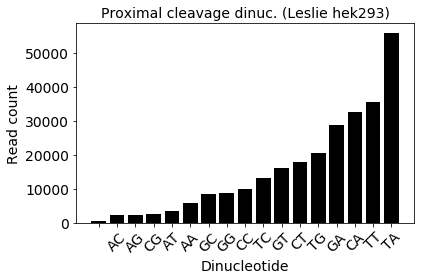

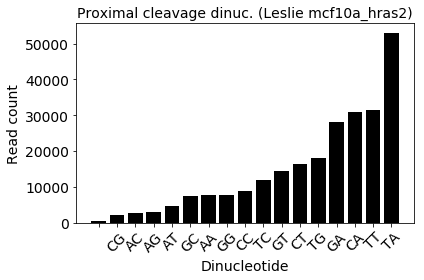

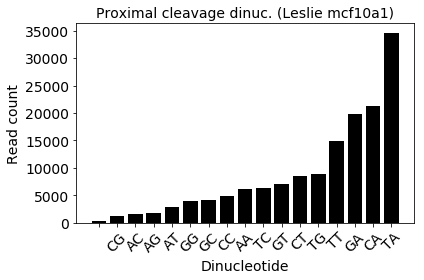

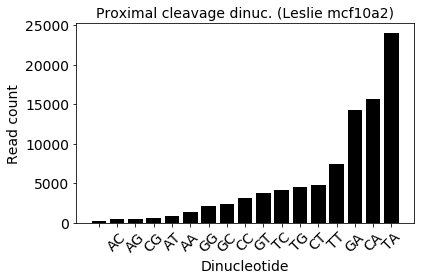

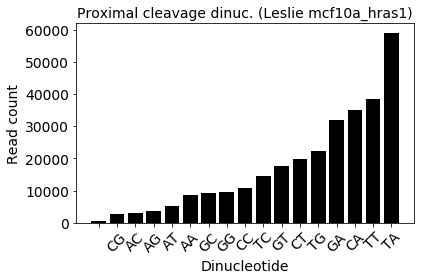

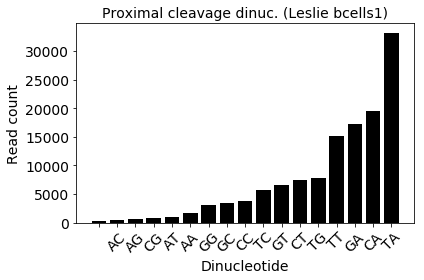

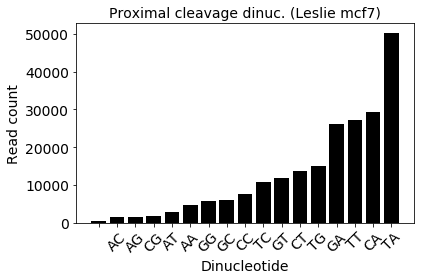

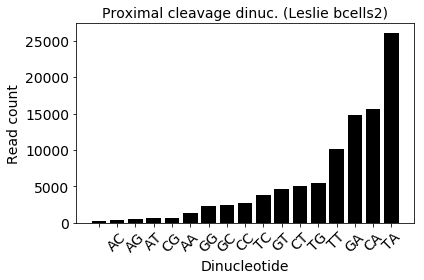

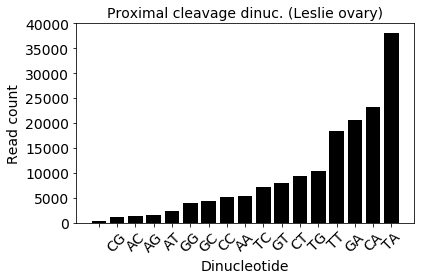

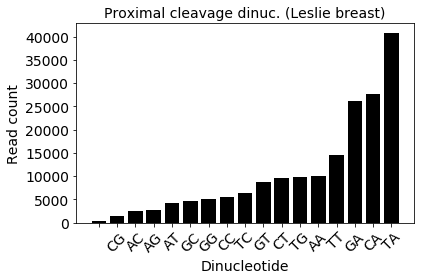

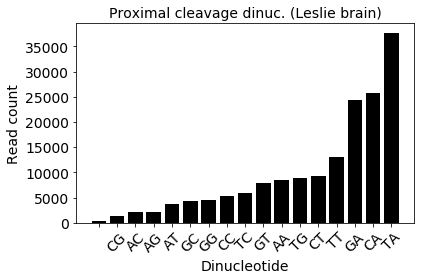

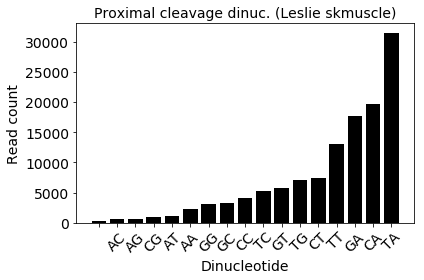

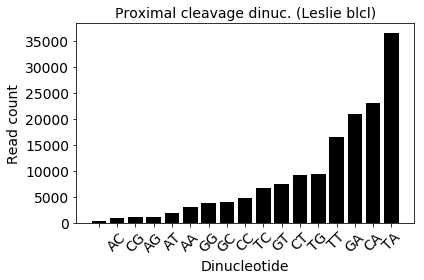

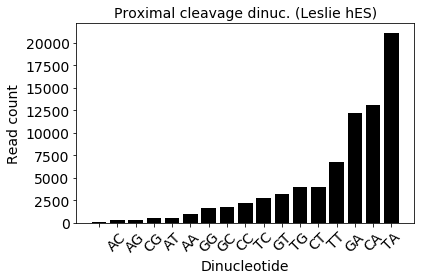

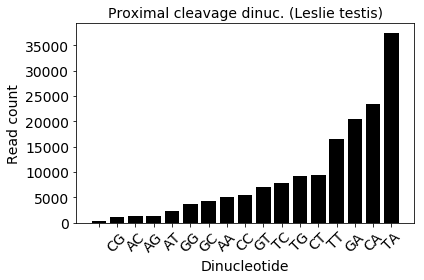

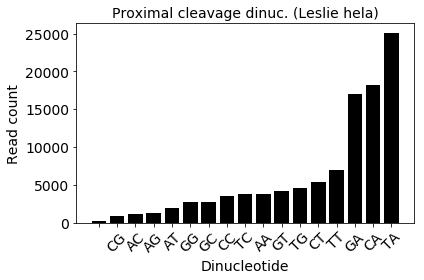

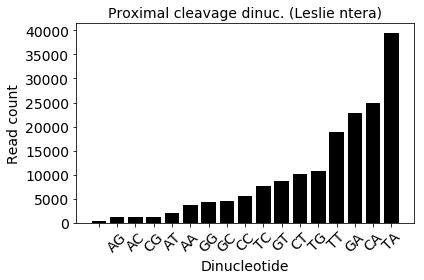

In [4]:
for tissue_i in range(0, len(leslie_tissue_index)) :
    cell_type = leslie_tissue_index[tissue_i]
    plot_cut_2mers(df, cell_type, leslie_cleavage_count_dict[cell_type], seq_column='seq')

Read depth across Leslie pA site measurements (Mean/Pooled across cell types).


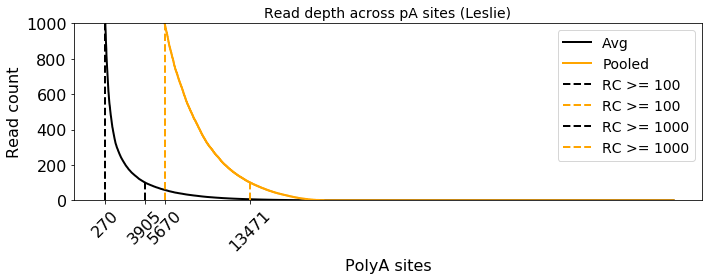

Read depth across APADB pA site measurements (Mean/Pooled across tissues).


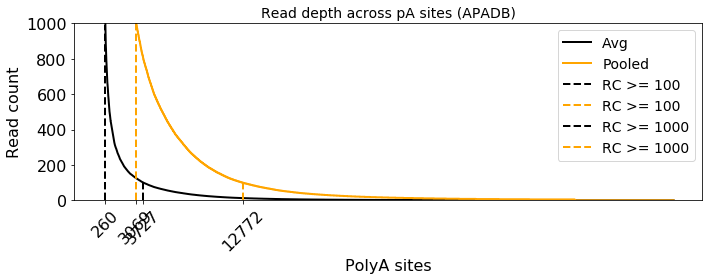

In [8]:
print("Read depth across Leslie pA site measurements (Mean/Pooled across cell types).")
plot_read_coverage_distribution(leslie_isoform_count, 'Leslie')

print("Read depth across APADB pA site measurements (Mean/Pooled across tissues).")
plot_read_coverage_distribution(apadb_isoform_count, 'APADB')

Leslie total read count statistics per cell type.


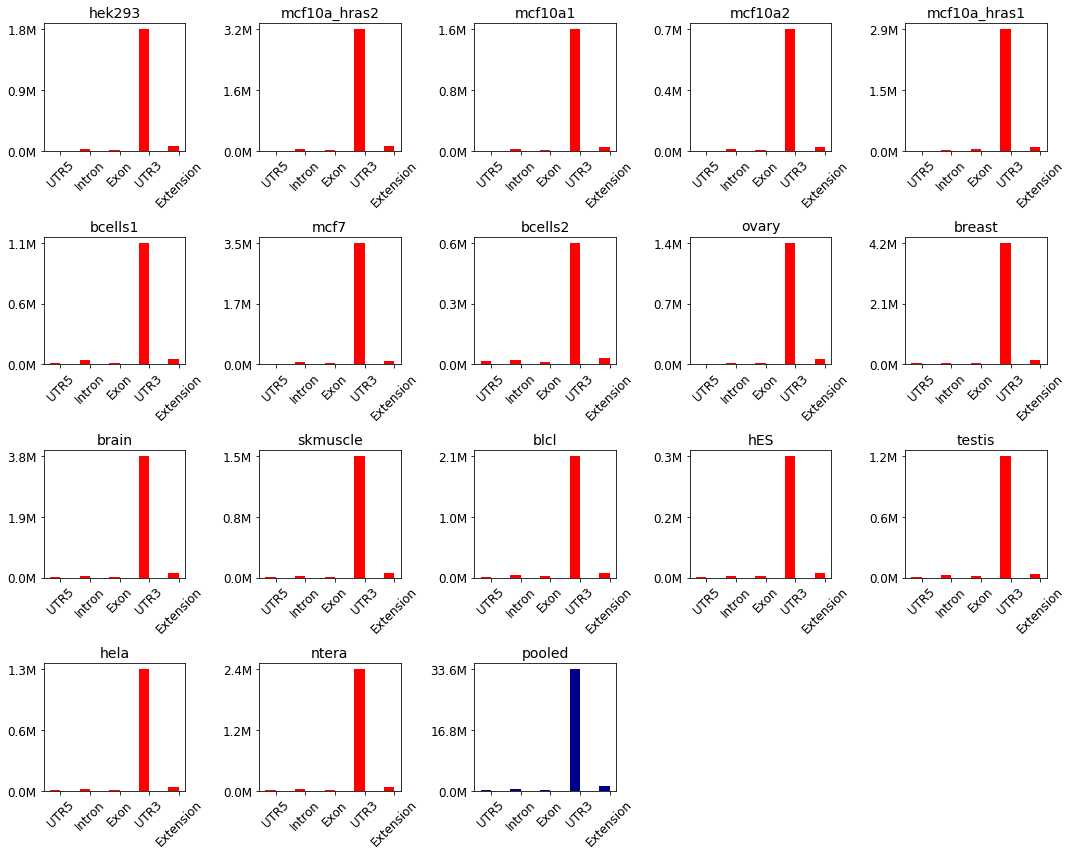

APADB total read count statistics per tissue.


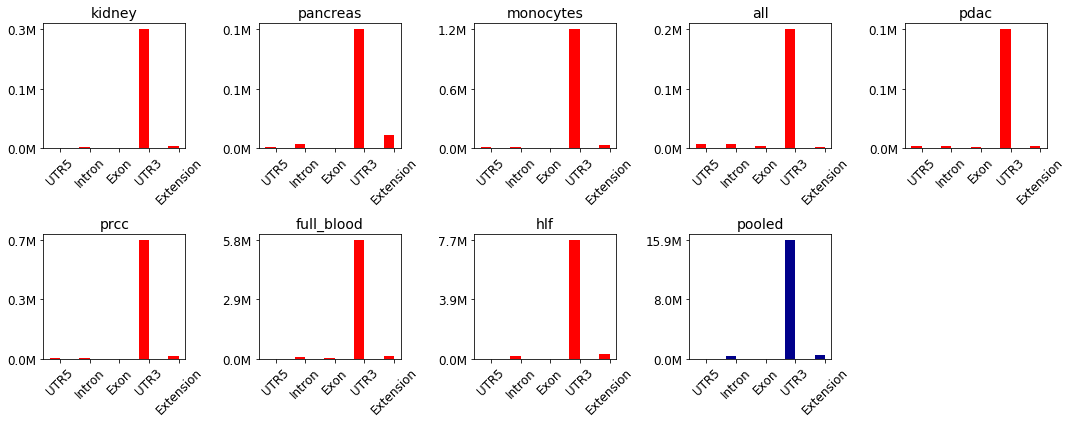

In [6]:
print('Leslie total read count statistics per cell type.')
leslie_tissue_index_extended = np.concatenate([leslie_tissue_index, np.array(['pooled'])])
plot_tissue_read_count_histo(df, 'leslie', leslie_tissue_index_extended, n_rows=4, n_cols=5)

print('APADB total read count statistics per tissue.')
apadb_tissue_index_extended = np.concatenate([apadb_tissue_index, np.array(['pooled'])])
plot_tissue_read_count_histo(df, 'apadb', apadb_tissue_index_extended, n_rows=2, n_cols=5)

Fraction of intronic pA reads across Leslie cell types.


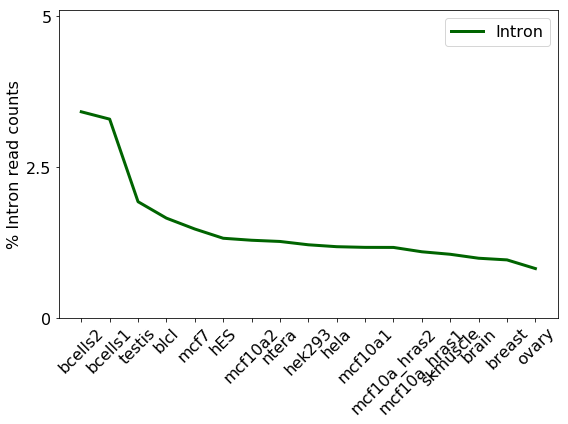

Fraction of intronic pA reads across APADB cell types.


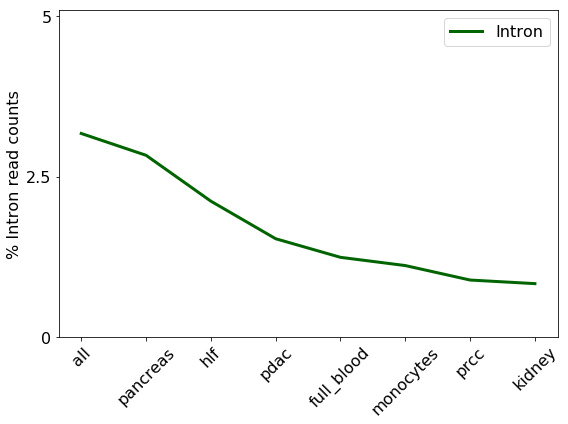

In [7]:
print('Fraction of intronic pA reads across Leslie cell types.')
plot_site_type_fractions(df, 'leslie', leslie_tissue_index)

print('Fraction of intronic pA reads across APADB cell types.')
plot_site_type_fractions(df, 'apadb', apadb_tissue_index)

Leslie total site usage correlation (across cell types, total site usage).


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


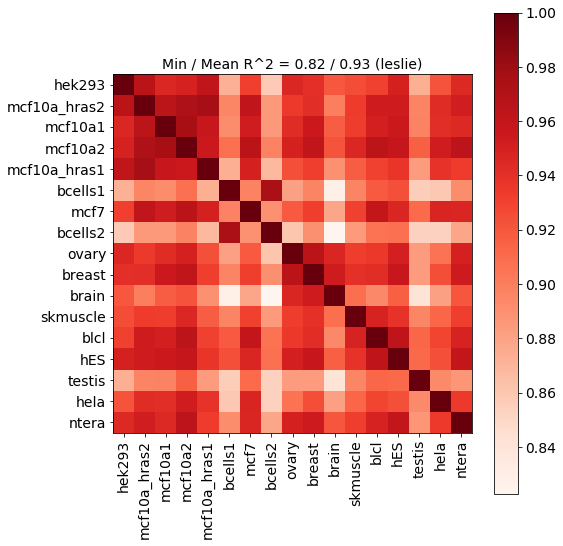

APADB total site usage correlation (across cell types, total site usage).


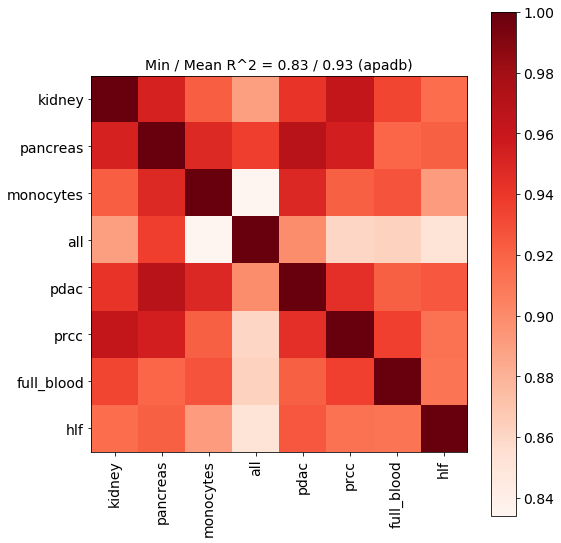

In [6]:
#Differential total site usage analysis
site_nums = None
site_types = ['UTR3', 'Extension']
pseudo_count = 0.1
min_total_count = 20
only_differentials = False
use_logodds = False
fixed_isoform_difference = 0.25


print("Leslie total site usage correlation (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='total_count')
plot_differential_usage_heatmap(r2_map, source_data, tissue_index)

print("APADB total site usage correlation (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='total_count')
plot_differential_usage_heatmap(r2_map, source_data, tissue_index)


Leslie mean isoform usage difference (across cell types, total site usage).


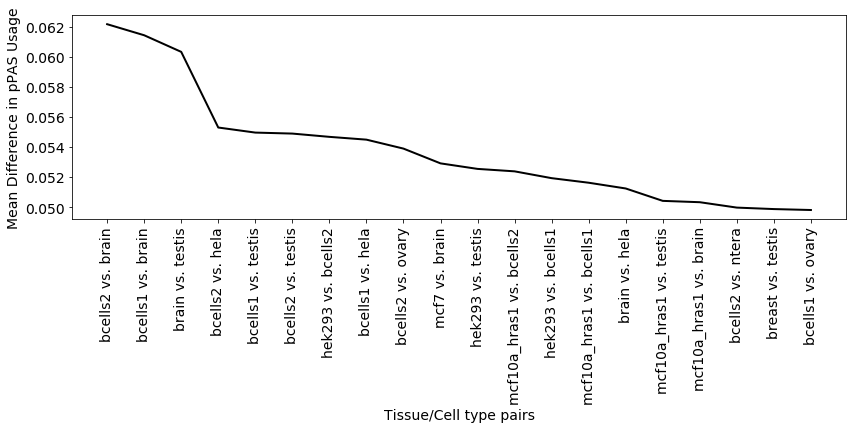

APADB mean isoform usage difference (across cell types, total site usage).


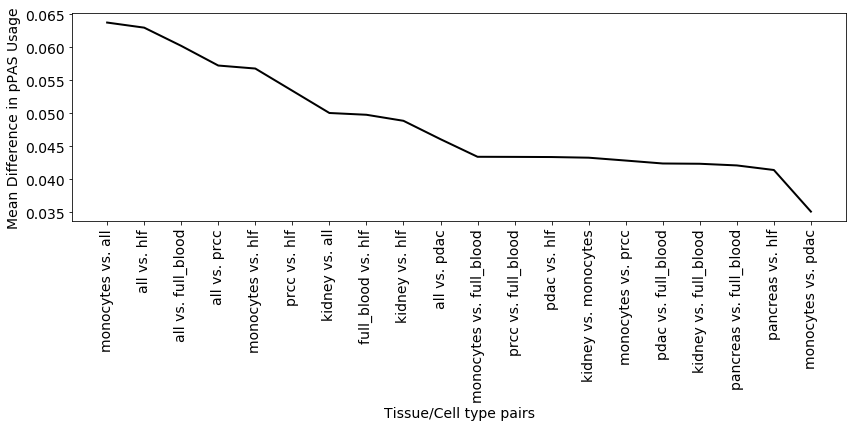

In [10]:
print("Leslie mean isoform usage difference (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='total_count')
plot_mean_absolute_difference(mae_map, tissue_index, top_n=20)

print("APADB mean isoform usage difference (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='total_count')
plot_mean_absolute_difference(mae_map, tissue_index, top_n=20)


Leslie fraction of sites with high differential usage (across cell types, total site usage).


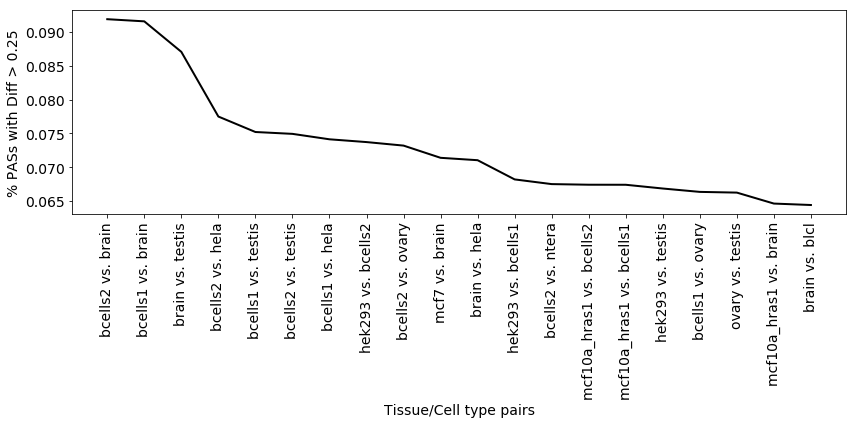

APADB fraction of sites with high differential usage (across cell types, total site usage).


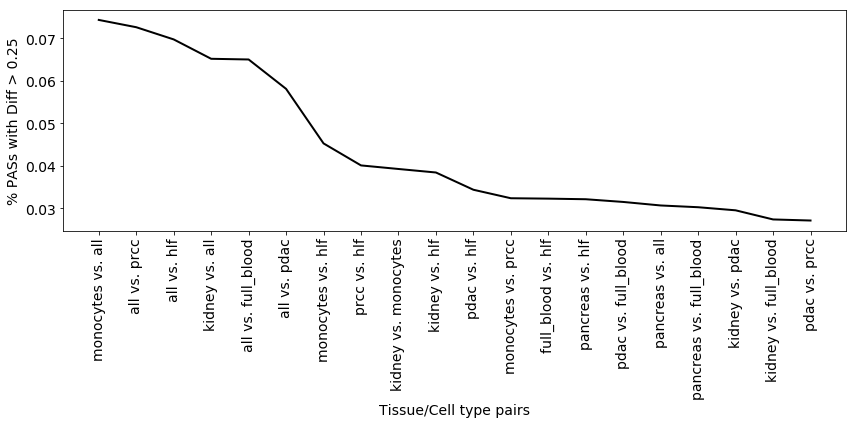

In [9]:
print("Leslie fraction of sites with high differential usage (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='total_count')
plot_fraction_of_isoform_difference(fixed_isoform_diff_map, tissue_index, fixed_isoform_difference, top_n=20)

print("APADB fraction of sites with high differential usage (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='total_count')
plot_fraction_of_isoform_difference(fixed_isoform_diff_map, tissue_index, fixed_isoform_difference, top_n=20)


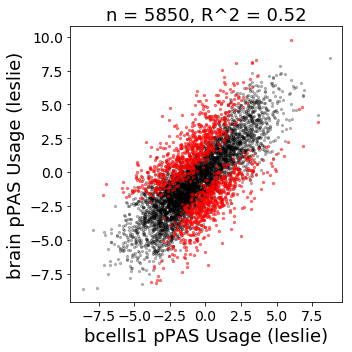

In [4]:
#Differential total site usage analysis, individual scatter
site_nums = None#[1, 2, 3, 4, 5]
site_types = ['UTR3']
pseudo_count = 0.0#0.1#1.0#0.0
min_total_count = 20#100
only_differentials = True
use_logodds = True
color_by_sitenum = False

source_data_1 = 'leslie'
tissue_1 = 'bcells1'
special_mode_1 = '_apadb_region'
tissue_1_info = (source_data_1, tissue_1, special_mode_1)

source_data_2 = 'leslie'
tissue_2 = 'brain'
special_mode_2 = '_apadb_region'
tissue_2_info = (source_data_2, tissue_2, special_mode_2)

plot_individual_differential_scatter(df, tissue_1_info, tissue_2_info, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, total_count_str='total_count', color_significant_sites=True)

Intronic, Exonic and 3' UTR Cleavage distribution pooled across cell types (Leslie data).


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


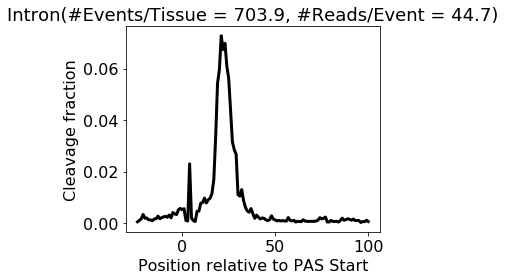

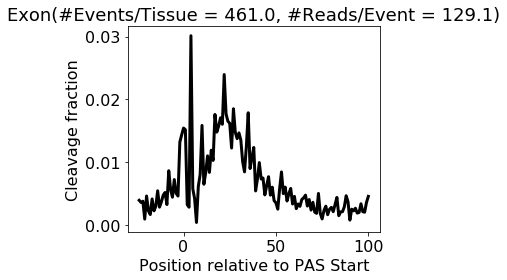

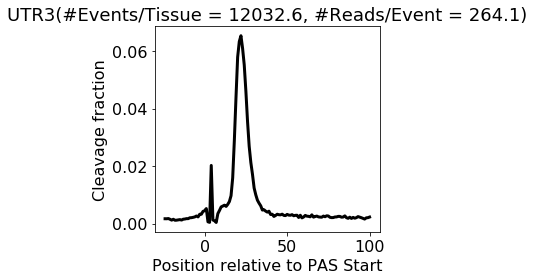

3' UTR Cleavage distribution per cell type (Leslie data).


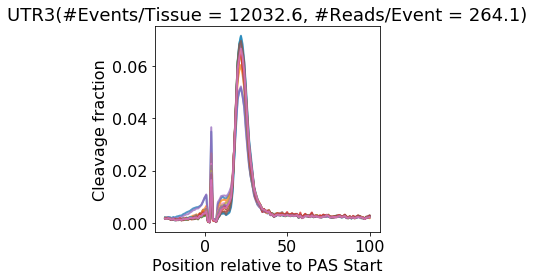

In [4]:
#Mean of normalized cleavage counts, pooled and per cell type of the Leslie dataset

print('Intronic, Exonic and 3\' UTR Cleavage distribution pooled across cell types (Leslie data).')
plot_cut_distributions(df, leslie_tissue_index, leslie_cleavage_count_dict, ['Intron', 'Exon', 'UTR3'], plot_tissue_specific=False, plot_pooled=True)

print('3\' UTR Cleavage distribution per cell type (Leslie data).')
plot_cut_distributions(df, leslie_tissue_index, leslie_cleavage_count_dict, ['UTR3'], plot_tissue_specific=True, plot_pooled=False)


Predicted vs. Observed mean cut position per tissue (scatter dots = PAS sequences).


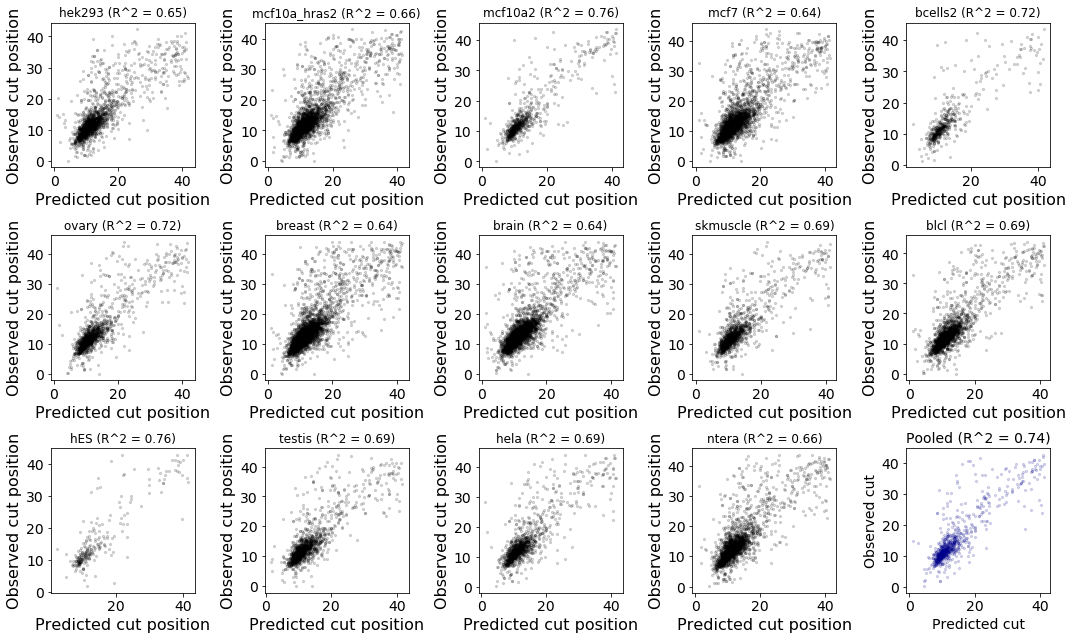

In [5]:
print("Predicted vs. Observed mean cut position per tissue (scatter dots = PAS sequences).")
plot_pred_vs_observed_mean_cut(df, leslie_cleavage_count_dict, pred_cleavage_prob, leslie_tissue_index)

Predicted vs. Observed mean cut position per tissue (correlation bar chart).


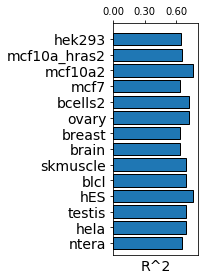

In [6]:
print("Predicted vs. Observed mean cut position per tissue (correlation bar chart).")
plot_pred_vs_observed_mean_cut_bar(df, leslie_cleavage_count_dict, pred_cleavage_prob, leslie_tissue_index)

Leslie pair-wise APA site usage correlation (across cell types).


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


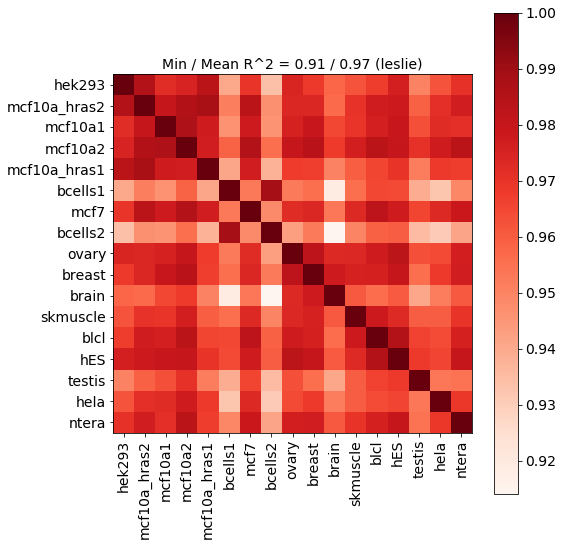

APADB pair-wise APA site usage correlation (across cell types).


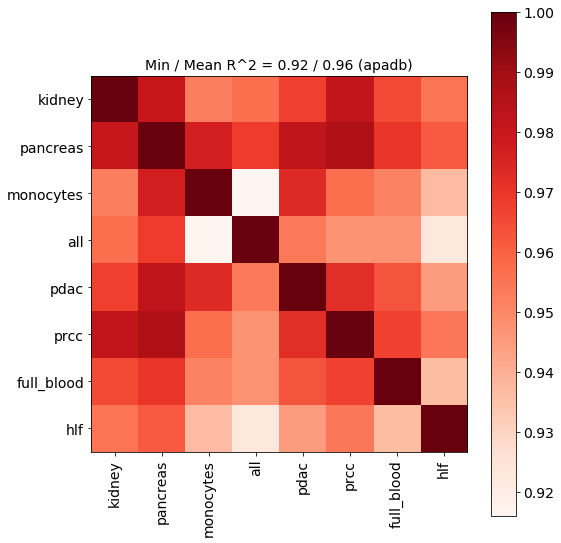

In [3]:
#Differential pair-wise APA site usage analysis
site_nums = None
site_types = ['UTR3', 'Extension']
pseudo_count = 0.1
min_total_count = 20
only_differentials = False
use_logodds = False
fixed_isoform_difference = 0.25


print("Leslie pair-wise APA site usage correlation (across cell types).")

[source_data, tissue_index, suffix_index] = ('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(pair_df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='pair_count')
plot_differential_usage_heatmap(r2_map, source_data, tissue_index)

print("APADB pair-wise APA site usage correlation (across cell types).")

[source_data, tissue_index, suffix_index] = ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(pair_df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='pair_count')
plot_differential_usage_heatmap(r2_map, source_data, tissue_index)


Leslie mean isoform usage difference (across cell types, total site usage).


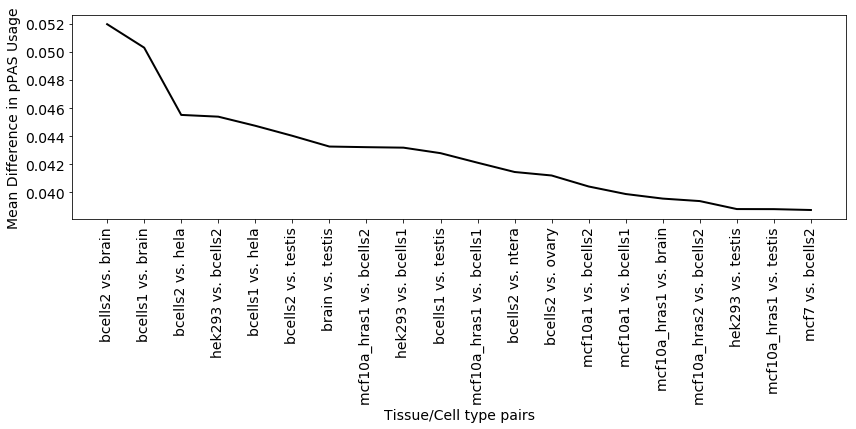

APADB mean isoform usage difference (across cell types, total site usage).


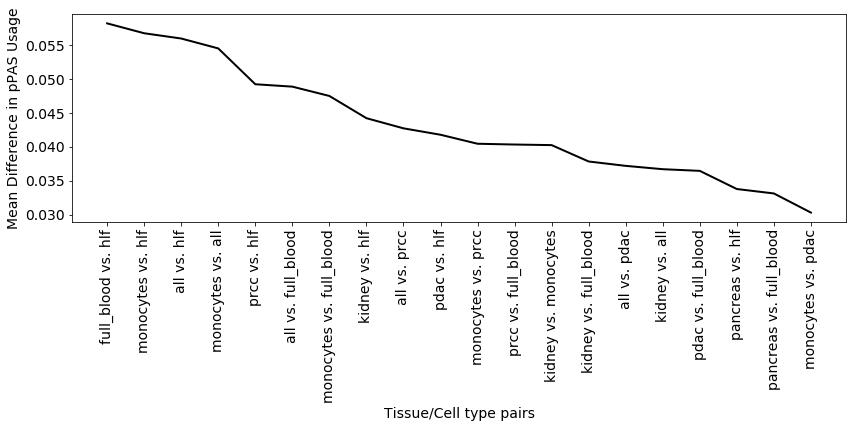

In [4]:
print("Leslie mean isoform usage difference (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(pair_df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='pair_count')
plot_mean_absolute_difference(mae_map, tissue_index, top_n=20)

print("APADB mean isoform usage difference (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(pair_df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='pair_count')
plot_mean_absolute_difference(mae_map, tissue_index, top_n=20)


Leslie fraction of sites with high differential usage (across cell types, total site usage).


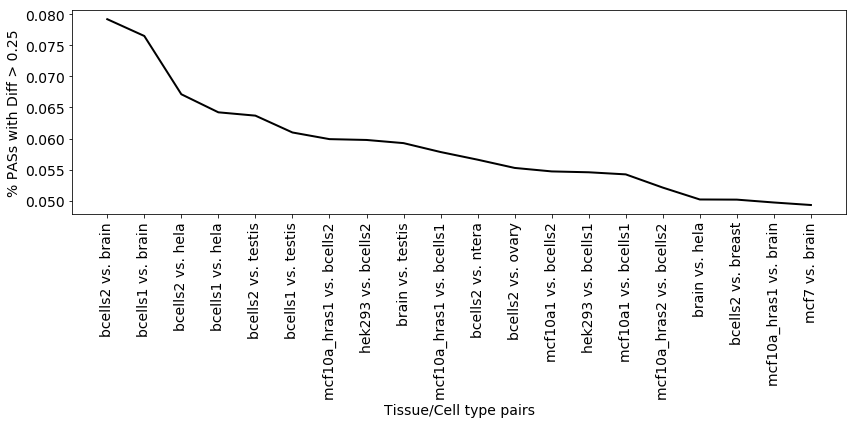

APADB fraction of sites with high differential usage (across cell types, total site usage).


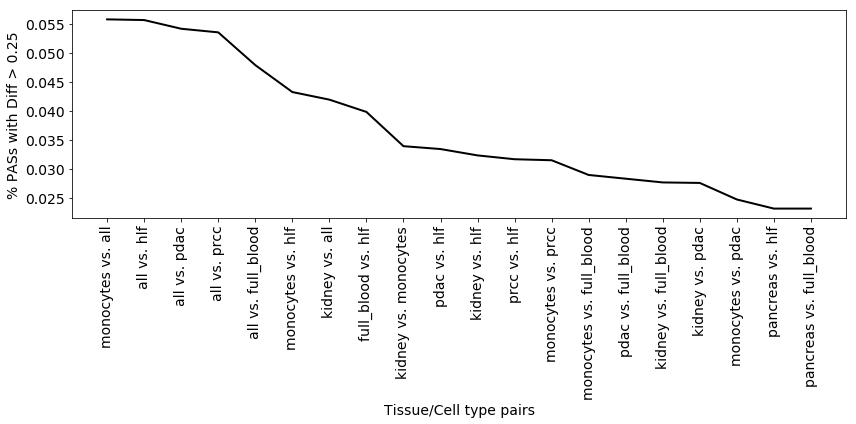

In [5]:
print("Leslie fraction of sites with high differential usage (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('leslie', leslie_tissue_index, np.array(['_apadb_region'] * leslie_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(pair_df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='pair_count')
plot_fraction_of_isoform_difference(fixed_isoform_diff_map, tissue_index, fixed_isoform_difference, top_n=20)

print("APADB fraction of sites with high differential usage (across cell types, total site usage).")

[source_data, tissue_index, suffix_index] = ('apadb', apadb_tissue_index, np.array([''] * apadb_tissue_index.shape[0], dtype=np.object))
r2_map, mae_map, fixed_isoform_diff_map = get_differential_usage_statistics(pair_df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, min_total_count, only_differentials, use_logodds, fixed_isoform_difference, total_count_str='pair_count')
plot_fraction_of_isoform_difference(fixed_isoform_diff_map, tissue_index, fixed_isoform_difference, top_n=20)


APADB pair-wise APA site usage prediction performance (using Pooled-APADB fitted APARENT model).


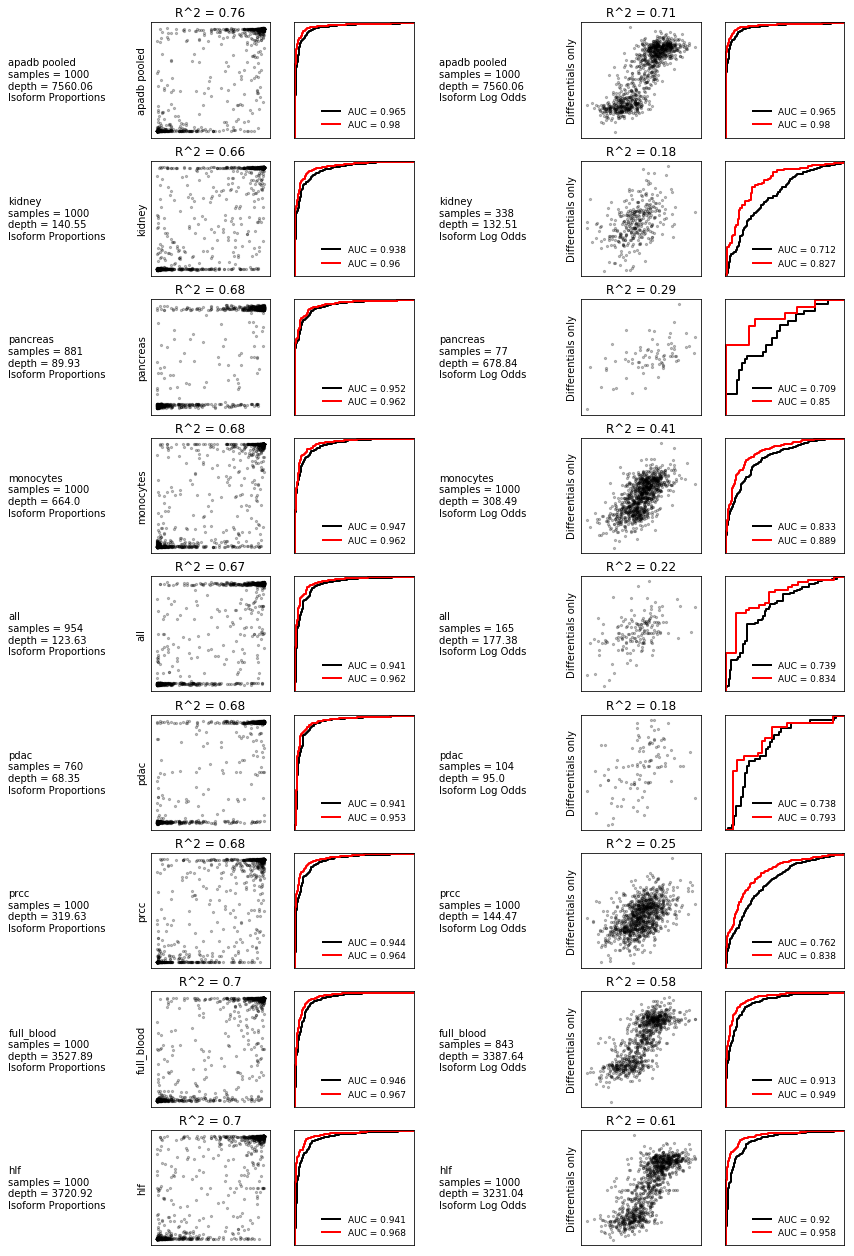

In [3]:
#Multiplex analysis of cell type-specific APA isoform prediction accuracy (APADB)
site_nums = None
site_types = ['UTR3', 'Extension']
pseudo_count = 0.5
max_n_members = 1000

print("APADB pair-wise APA site usage prediction performance (using Pooled-APADB fitted APARENT model).")

[source_data, tissue_index, suffix_index] = ('apadb', ['pooled'] + apadb_tissue_index.tolist(), np.array([''] * (apadb_tissue_index.shape[0] + 1), dtype=np.object))

apadb_r2_tissues, apadb_auc_tissues, apadb_n_samples_tissues, apadb_read_depth_tissues, apadb_rocs = evaluate_predicted_vs_observed_tissues(pair_df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, max_n_members)


APADB Num APA Sites and Mean Read Depth.


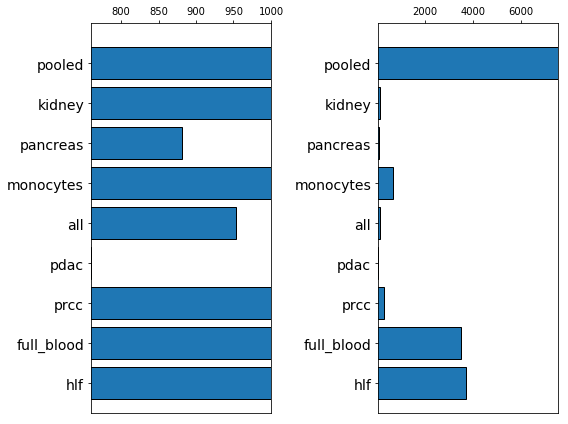

APADB Isoform Usage R^2 and Preferential Usage AUC.


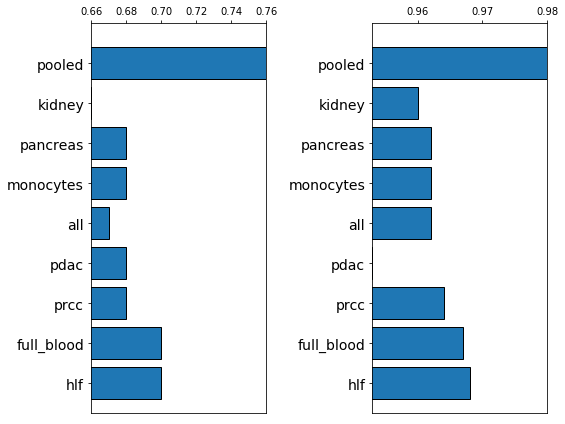

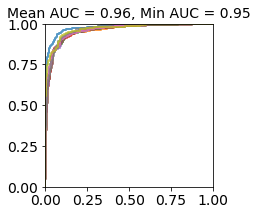

In [4]:
print('APADB Num APA Sites and Mean Read Depth.')

plot_performance_double_bar(tissue_index, apadb_n_samples_tissues, apadb_read_depth_tissues)

print('APADB Isoform Usage R^2 and Preferential Usage AUC.')

plot_performance_double_bar(tissue_index, apadb_r2_tissues, apadb_auc_tissues)

#Plot ROCs
f = plt.figure(figsize=(3, 3))
for tissue_i, tissue in enumerate(tissue_index) :
    fpr, tpr = apadb_rocs[tissue_i]
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75)

min_auc = np.min(apadb_auc_tissues)
mean_auc = np.mean(apadb_auc_tissues)
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)), fontsize=14)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)

plt.show()

Leslie pair-wise APA site usage correlation (across cell types).


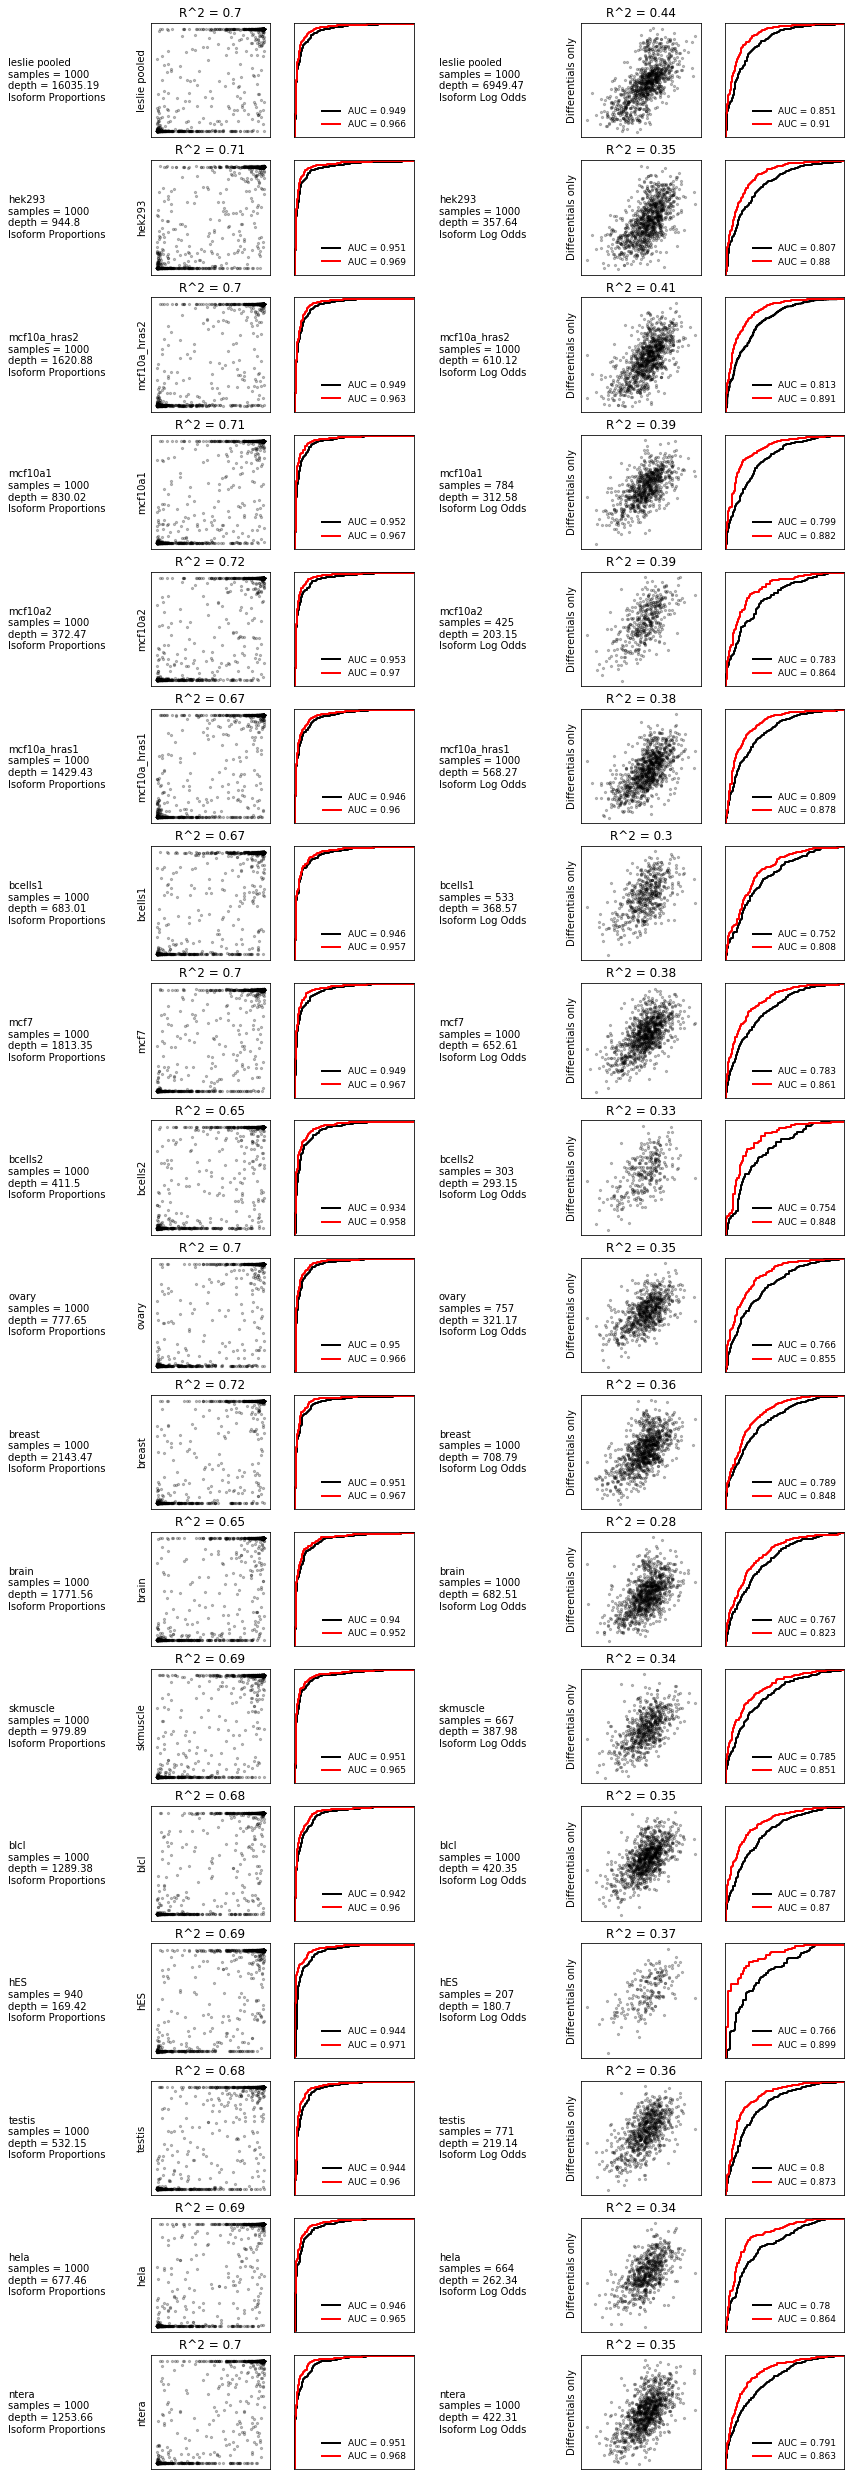

In [5]:
#Multiplex analysis of cell type-specific APA isoform prediction accuracy (Leslie)
site_nums = None
site_types = ['UTR3', 'Extension']
pseudo_count = 0.5
max_n_members = 1000

print("Leslie pair-wise APA site usage correlation (across cell types).")

[source_data, tissue_index, suffix_index] = ('leslie', ['pooled'] + leslie_tissue_index.tolist(), np.array(['_apadb_region'] * (leslie_tissue_index.shape[0] + 1), dtype=np.object))

leslie_r2_tissues, leslie_auc_tissues, leslie_n_samples_tissues, leslie_read_depth_tissues, leslie_rocs = evaluate_predicted_vs_observed_tissues(pair_df, source_data, tissue_index, suffix_index, site_nums, site_types, pseudo_count, max_n_members)


APADB Num APA Sites and Mean Read Depth.


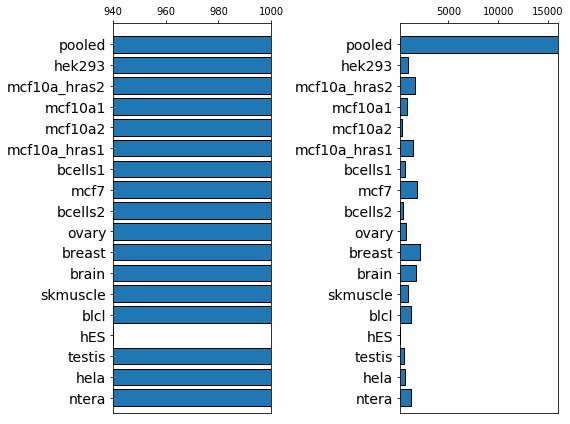

APADB Isoform Usage R^2 and Preferential Usage AUC.


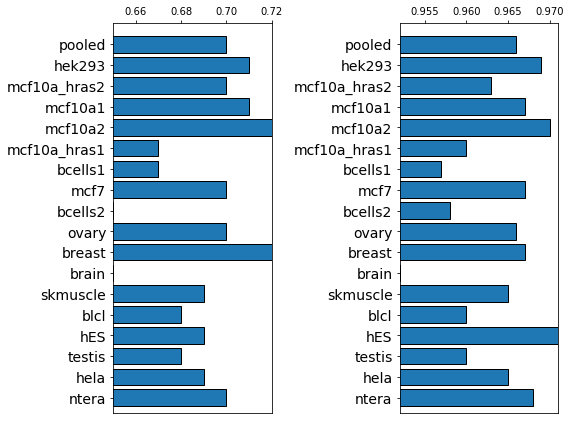

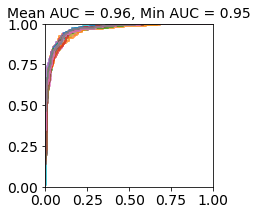

In [6]:
print('APADB Num APA Sites and Mean Read Depth.')

plot_performance_double_bar(tissue_index, leslie_n_samples_tissues, leslie_read_depth_tissues)

print('APADB Isoform Usage R^2 and Preferential Usage AUC.')

plot_performance_double_bar(tissue_index, leslie_r2_tissues, leslie_auc_tissues)

#Plot ROCs
f = plt.figure(figsize=(3, 3))
for tissue_i, tissue in enumerate(tissue_index) :
    fpr, tpr = leslie_rocs[tissue_i]
    plt.plot(fpr, tpr, linewidth=2, alpha=0.75)

min_auc = np.min(leslie_auc_tissues)
mean_auc = np.mean(leslie_auc_tissues)
plt.title('Mean AUC = ' + str(round(mean_auc, 2)) + ', Min AUC = ' + str(round(min_auc, 2)), fontsize=14)

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)

plt.show()